In [1]:
#########################################################################
# LIBRERIAS NECESARIAS
#########################################################################
import gymnasium as gym
import numpy as np
import sinergym
from sinergym.utils.wrappers import LoggerWrapper
import torch

import tensorflow as tf
from stable_baselines3 import PPO
from tensorflow.keras.layers import concatenate
import keras
import matplotlib.pyplot as plt
from keras import layers
import copy
from sklearn.model_selection import train_test_split
import csv

import os
from stable_baselines3.common.vec_env import DummyVecEnv        

2023-11-07 05:58:11.089639: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-07 05:58:11.251872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-07 05:58:12.023920: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
############################################################################
# Variables globales
###########################################################################
BATCH_SIZE = 28032
EPOCHS =100
EPISODES = 1
EPISODES_EVALUATE_G=5
TOTAL_TIMESTEPS_PPO_GENERATOR=250

In [3]:
# Definimos el entorno Datacenter
env = gym.make('Eplus-office-hot-discrete-v1')
env = LoggerWrapper(env)

# Obtenemos el espacio de observaciones y el espacio de acciones del entorno env
ob_space = env.observation_space
ac_space = env.action_space

# Mostramos el número de observaciones y de acciones del entorno 5Zone
print('\n Nº de observaciones: ', ob_space.shape[0])
print('\n Nº de acciones: ', ac_space.n)

[2023-11-07 05:58:13,920] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model ExternalInterface object if it is not present...
[2023-11-07 05:58:13,920] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Updating Building model Site:Location and SizingPeriod:DesignDay(s) to weather and ddy file...
[2023-11-07 05:58:13,921] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Updating building model OutPut:Variable and variables XML tree model for BVCTB connection.
[2023-11-07 05:58:13,922] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Setting up extra configuration in building model if exists...
[2023-11-07 05:58:13,922] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Setting up action definition in building model if exists...

 Nº de observaciones:  26

 Nº de acciones:  10


/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.variables to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.variables` for environment variables or `env.get_wrapper_attr('variables')` that will search the reminding wrappers.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gymnasium/core.py:311: UserWarning: WARN: env.simulator to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.simulator` for environment variables or `env.get_wrapper_attr('simulator')` that will search the reminding wrappers.
  logger.warn(


# Discriminador

## Red neuronal del Discriminador

In [4]:
################################################################################################################################################
# Red neuronal del Discriminador
################################################################################################################################################

# Input: secuencias [s,a, s', r] reales o falsas, de longitud 2*ob_space.shape[0] + ac_space.n+1. 
# Output: probabilidad de real o falso perteneciente al intervalo [0,1]
discriminator_net = keras.Sequential(
    [
        keras.Input(shape=(None, 2*ob_space.shape[0] + ac_space.n+1)),
        layers.Dense(units=25, activation=tf.nn.relu, name='layer1'),
        layers.Dense(units=25, activation=tf.nn.relu, name='layer2'),
        layers.Dense(units=25, activation=tf.nn.relu, name='layer3'),
        layers.Dense(units=1, activation=tf.sigmoid, name='prob'),

    ],
    name="discriminator_net"

)
discriminator_net.summary()

Model: "discriminator_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 25)          1600      
                                                                 
 layer2 (Dense)              (None, None, 25)          650       
                                                                 
 layer3 (Dense)              (None, None, 25)          650       
                                                                 
 prob (Dense)                (None, None, 1)           26        
                                                                 
Total params: 2926 (11.43 KB)
Trainable params: 2926 (11.43 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del Discriminador 

In [5]:
#########################################################################################################
# Función de pérdida del Discriminador
#########################################################################################################

# prob1=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia REAL [s,a, s', r] de la base de datos 
# prob2=> output de la red neuronal del Discriminador cuando recibe como entrada una secuencia FALSA [s,a, s', r] 
def loss_fn_D(prob1, prob2):

    # Esperanza del logaritmo de la D(x)=salida de la red neuronal cuando x=entrada REAL
    loss_expert = tf.reduce_mean(tf.math.log(tf.clip_by_value(prob1, 0.01, 1)))
    
    # Esperanza del logaritmo de 1-D(x) donde D(x)=salida de la red neuronal cuando x=entrada FALSA
    loss_agent = tf.reduce_mean(tf.math.log(tf.clip_by_value(1 - prob2, 0.01,1)))
    
    loss_expert = tf.cast(loss_expert, dtype=tf.float32)
    loss_agent = tf.cast(loss_agent, dtype=tf.float32)
    
    loss = loss_expert + loss_agent
    
    loss = -loss

    return loss

## Clase del Discriminador 

In [6]:
class Discriminator:
    def __init__(self,env,discriminator_net,expert_s,expert_a,expert_s_prima,expert_r, agent_s,agent_a,agent_s_prima,agent_r):

        # -Red neuronal del Discriminador
        self.discriminator_net = discriminator_net

        # 1) Secuencia experta: [s,a,s',r]
        self.expert_s = expert_s
        self.expert_a = expert_a
        self.expert_s_prima=expert_s_prima
        self.expert_r= np.array(expert_r)
        
        expert_a_one_hot = tf.one_hot(self.expert_a, depth=env.action_space.n)
        # Añadimos ruido para estabilizar el entrenamiento
        expert_a_one_hot += tf.random.normal(tf.shape(expert_a_one_hot),mean=0.2,stddev=0.1,dtype=tf.float32) / 1.2
        expert_s_a = tf.concat([self.expert_s, expert_a_one_hot], axis=1)
        expert_s_a_s=tf.concat([expert_s_a, self.expert_s_prima], axis=1)

        self.expert_r=self.expert_r.reshape(-1, 1)

        # expert_s_a_s_r=>secuencia experta=>[s,a,s',r]
        self.expert_s_a_s_r=tf.concat([expert_s_a_s, self.expert_r], axis=1)

        # 2) Secuencia agente:  [s,a,s',r]
        self.agent_s = agent_s
        self.agent_a = agent_a
        self.agent_s_prima=agent_s_prima
        self.agent_r=np.array(agent_r)
        
        agent_a_one_hot = tf.one_hot(self.agent_a, depth=env.action_space.n)

        agent_a_one_hot += tf.random.normal(tf.shape(agent_a_one_hot),mean=0.2,stddev=0.1,dtype=tf.float32) / 1.2
        agent_s_a = tf.concat([self.agent_s, agent_a_one_hot], axis=1)
        agent_s_a_s=tf.concat([agent_s_a, self.agent_s_prima], axis=1)
        self.agent_r=self.agent_r.reshape(-1, 1)

        # agent_s_a_s_r=>secuencia agente=>[s,a,s',r]
        self.agent_s_a_s_r=tf.concat([agent_s_a_s, self.agent_r], axis=1)

        # Calculamos la salida de la red para [s,a,s',r] del experto y [s,a,s',r] del agente 

        # -Salida de la red neuronal Discriminador para [s,a,s',r] expertos(verdaderos)
        self.prob_expert = self.discriminator_net(self.expert_s_a_s_r)

        # -Salida  de la red neuronal Discrimiinador para [s,a,s',r] Agente(falsos)
        self.prob_agent = self.discriminator_net(self.agent_s_a_s_r)

        # -Recompensa obtenida cuando el Agente realiza [s,a,s',r] falsas
        self.rewards = tf.math.log(tf.clip_by_value(self.prob_agent, 1e-10, 1))

    def getNet(self):
        return self.discriminator_net

    def getAgent_S_A(self):
        return self.agent_s_a_s_r

    def getExpert_S_A(self):
        return self.expert_s_a_s_r

    def getProb(self):
        return self.prob_expert, self.prob_agent

    def getRewards(self):
        return self.rewards

# Generador 

## Redes neuronales del generador

In [7]:
#####################################################################################################
# Red neuronal del Generador donde se producen acciones
####################################################################################################

# Input: estados, listas de tamaño 26, s=[s1,s2,s3,....,s26]
# Output: acciones, listas de tamaño 10, a=[a1,a2,....,a10]
generator_net_Act = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=22, activation=tf.tanh, name='layer1'),
        layers.Dense(units=22, activation=tf.tanh, name='layer2'),
        layers.Dense(units=15, activation=tf.tanh, name='layer3'),
        layers.Dense(units=ac_space.n, activation=tf.nn.softmax, name='layer4')

    ],
    name="generator_net_Act"
)

generator_net_Act.summary()

Model: "generator_net_Act"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 22)          594       
                                                                 
 layer2 (Dense)              (None, None, 22)          506       
                                                                 
 layer3 (Dense)              (None, None, 15)          345       
                                                                 
 layer4 (Dense)              (None, None, 10)          160       
                                                                 
Total params: 1605 (6.27 KB)
Trainable params: 1605 (6.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
####################################################################################
# Red neuronal del Generador donde se producen v_pred
###################################################################################
# Input: estados, listas de tamaño 26, s=[s1,s2,s3,....,s26]
# Output: v_pred, listas de tamaño 1, v_pred(s)

generator_net_v_preds = keras.Sequential(
    [
        keras.Input(shape=(None, ob_space.shape[0])),
        layers.Dense(units=22, activation=tf.tanh, name='layer1'),
        layers.Dense(units=22, activation=tf.tanh, name='layer2'),
        layers.Dense(units=1, activation=None, name='layer3'),
    ],
    name="generator_v_preds"
)

generator_net_v_preds.summary()

Model: "generator_v_preds"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, None, 22)          594       
                                                                 
 layer2 (Dense)              (None, None, 22)          506       
                                                                 
 layer3 (Dense)              (None, None, 1)           23        
                                                                 
Total params: 1123 (4.39 KB)
Trainable params: 1123 (4.39 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Función de pérdida del generador 

In [9]:
# Función de pérdida del Generador: función objetivo de PPO "clipped surrogated" 
def loss_fn_ppo(act_probs,act_probs_old,gaes,clip_value=0.2):
    ratios = tf.exp(tf.math.log(tf.clip_by_value(act_probs, 1e-10, 1.0))
                    - tf.math.log(tf.clip_by_value(act_probs_old, 1e-10, 1.0)))

    clipped_ratios = tf.clip_by_value(ratios,clip_value_min=1 -clip_value,clip_value_max=1 +clip_value)
    loss_clip = tf.minimum( tf.multiply(gaes, ratios), tf.multiply(gaes, clipped_ratios))
    loss_clip = tf.reduce_mean(loss_clip)
    
    loss = -loss_clip
    tf.summary.scalar('total', loss)

    return loss

## Clase del generador 

In [10]:
#################################################################################################################
# Clase del GENERADOR: política con su optimizador PPO
################################################################################################################

# Observesé que cada generador implementa una política distinta, por tanto, se ha decidido llamar a la clase Policy_net en lugar de generator

class Policy_net:
    def __init__(self, name: str, env, obs):
        """
        name: string
        env: gym env
        obs:
        """

        # -Entorno
        self.env = env
        env.reset()

        # -Modelo PPO: algoritmo de Optimización de Política Proximal  
        self.model = PPO(policy="MlpPolicy", env=env, verbose=0)

        self.model.learn(total_timesteps=TOTAL_TIMESTEPS_PPO_GENERATOR)  

        # -Observación inicial a partir de la cual se crean las acciones iniciales haciendo uso de las redes neuronales del generador
        self.obs = np.reshape(np.array(obs), (1, ob_space.shape[0]))

        # Utilizamos las dos redes neuronales que hemos creado : generator_net_Act y generator_net_v_preds
        # V_pred=>recompensa media de que un agente ejecute una acción

        # -Acción inicial generada con red neuronal y v_pred con red neuronal
        self.act_probs = generator_net_Act(self.obs)
        self.v_preds = generator_net_v_preds(self.obs)

        # -Accion estocástica inicial
        self.act_stochastic = tf.random.categorical(tf.math.log(self.act_probs), num_samples=1)

        # -Acción determinística inicial
        self.act_deterministic = tf.argmax(self.act_probs, axis=1)

    # Para cada estado obs me dice la acción que el agente va a ejecutar sobre el entorno junto con v_pred
    # La elección de la acción puede ser estocástica o determinística
    def act(self, stochastic=True):
        if stochastic:
            return self.act_stochastic, self.v_preds
        else:
            return self.act_deterministic, self.v_preds

    def get_action_prob(self):
        return self.act_probs

    def get_v_preds(self):
        return self.v_preds

    def get_obs(self):
        return self.obs

    def get_model(self):
        return self.model

    def get_trainable_variables(self):
        return self.model.get_parameters()

    # Generar [s,a,s',r] falsos
    def generate_fakes(self):

        ob_space = env.observation_space
        reward = 0
        success_num = 0

        # Por cada episodio
        for iteration in range(EPISODES):
            # Inicializo todas las variables
            observations = []
            actions = []
            rewards = []
            next_observations=[]

            run_policy_steps = 0

            truncated = False
            terminated = False

            # La primera acción de cada episodio se crea con el método act: un método que hace uso de la red neuronal que asigna probabilidades a las acciones en función del estado inicial y en base a ello, seleccio la acción estocástica inicial. 
            obs,_ = env.reset()

            Old_Policy = Policy_net('old_policy', env, obs=[obs])

            act, _ = Old_Policy.act(stochastic=True)

            # Convertir de tensor a array
            if type(act)=='Tensor':
                # Crear una sesión de TensorFlow
                sess = tf.compat.v1.Session()

                # Evaluar el tensor dentro de la sesión y obtener el resultado como un objeto NumPy ndarray
                act = sess.run(act)

                # Cerrar la sesión
                sess.close()

            if isinstance(act, tf.Tensor):
                act = act.numpy()

            elif isinstance(act, np.ndarray):
                act = act

            action = int(act)

            next_obs, reward, terminated, truncated, _ = env.step(action)

           

            # Tenemos una política entrenada
            Policy = Policy_net('policy', env, obs=[next_obs])

            # Por cada steps en cada episodio, mientras no se llegue a un estado terminal o un estado malo
            while terminated != True and truncated != True:
                # --Aumentar el numero de steps
                run_policy_steps += 1

                # --Política para ver la acción asociada al estado
                # Las observaciones son un de la forma [[s_0,s_1,s_2,....]] por eso su tamaño es (1,n)
                observations.append(next_obs)  # S_i-1 

                action, _ = Policy.get_model().predict(next_obs)

                action = int(action)

                # --Muevo al Agente al siguiente estado
                next_obs, reward, terminated, truncated, _ = env.step(action)

                # --Actualización de variables
                actions.append(action)  # A_i-1
                rewards.append(reward)  # R_i-1

                # --Si llegamos a un estado final, el juego ha finalizado!!!
                # --Se configura el tablero de nuevo
                if terminated:
                    next_observations.append(next_obs)  # S_i
                    obs = env.reset()
                    reward = -1
                    break
                else:
                    next_observations.append(next_obs)  # S_i
                    self.obs = next_obs

            # Ver si el episodio ha obtendo una recompensa total igual o superior a 195
            if sum(rewards) >= 195:
                success_num += 1
                if success_num >= 100:
                    break
            else:
                success_num = 0

        observations = np.reshape(observations,newshape=[-1] + list(ob_space.shape))

        actions = np.array(actions).astype(dtype=np.int32)

        return observations, actions, next_observations, rewards, Old_Policy, Policy

In [11]:
##########################################################################################################
# Clase PPOTrain
##########################################################################################################
# Tenemos dos politica theta_i y theta_i+1
# Almacenamos dos políticas Policy_net(cada una de ella con su PPO) y calculamos el valor gaes a partir de valores gamma, clip_value, c_1, c_2
# Realizamos aqui el entrenamiento, cálculo de gradiente y función de pérdida del PPO para después usarlo en el generador de la GAN
class PPOTrain:

    def __init__(self,Policy,Old_Policy,obs,actions,rewards,gamma=0.95):
        """
        arg:
            Policy
            Old_Policy
            gamma
            clip_value
            c_1 parámetro para la diferencia de valores
            c_2 parámetro para el bonus de entropía
        """
        self.Policy = Policy
        self.Old_Policy = Old_Policy
        self.gamma = gamma
        self.obs = obs

        self.pi_trainable = self.Policy.get_trainable_variables()
        self.old_pi_trainable = self.Old_Policy.get_trainable_variables()

        policy_dict_ = self.pi_trainable["policy"]
        old_policy_dict_ = self.old_pi_trainable["policy"]

        self.pi = []
        if "policy" in self.pi_trainable and  "policy" in self.old_pi_trainable:
            for param_name, param_value in policy_dict_.items():
                # Elimino los pesos que hay en old_policy
                del old_policy_dict_[param_name]
                # Introduzco los pesos de old_policy rn policy
                old_policy_dict_[param_name] = param_value
                self.pi.append(param_value)
        else:
            print("No se encontró la política con el nombre: policy")

        # Le asignamos old_pi_trainable=pi_trainable ya que ajustaremos unos nuevos pi_trainable
        self.actions = actions
        self.rewards = rewards
        self.v_preds = self.Old_Policy.get_v_preds()
        self.v_preds_next = self.Policy.get_v_preds()
        
        #  La estimación de la función ventaja GAES (ver paper PPO)
        self.gaes = self.get_gaes(self.rewards,self.v_preds,self.v_preds_next)

        act_probs = self.Policy.get_action_prob()
        act_probs_old = self.Old_Policy.get_action_prob()

        # La probabilidad de las acciones del agente cuando toma la actual política
        act_probs = act_probs * tf.one_hot(indices=self.actions, depth=act_probs.shape[1])
        self.act_probs = tf.reduce_sum(act_probs, axis=1)

        # La probabilidad de las acciones del agente cuando toma la antigua política
        act_probs_old = act_probs_old * tf.one_hot(indices=self.actions, depth=act_probs_old.shape[1])
        self.act_probs_old = tf.reduce_sum(act_probs_old, axis=1)

        self.loss = loss_fn_ppo( self.act_probs, self.act_probs_old, self.gaes)

        self.optimizer =  tf.keras.optimizers.Adam(learning_rate=1e-4)

    def loss_fn_G(self):
        return loss_fn_ppo(self.act_probs, self.act_probs_old, self.gaes)

    def get_pi_trainable(self):
        return self.pi

    def get_optimizer(self):
        return self.optimizer

    def get_OldPolicy(self):
        return self.Old_Policy

    def get_Policy(self):
        return self.Policy

    def get_gaes(self, rewards, v_preds, v_preds_next):
        deltas = [r_t + self.gamma *v_next - v for r_t, v_next, v in zip(rewards,v_preds_next,v_preds)]
        # Calcular la estimación generative advantage (lambda = 1) (ver ppo paper eq(11))
        gaes = copy.deepcopy(deltas)
        for t in reversed(range(len(gaes) -1)):  # Es T-1, donde T es timestep con el que se ejecuta la política
            gaes[t] = gaes[t] + self.gamma * gaes[t + 1]
        return gaes

# Extended GAIL

In [12]:
##########################################################################
# CLASE Extended GAIL
##########################################################################

class GAN(keras.Model):
    # Constructor
    def __init__(self, discriminator, generator):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.i=0
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    # Compila el modelo GAN inicializando los optimizadores y la función de pérdida del modelo GAN
    def compile(self, d_optimizer, loss_fn_D):
        super(GAN, self).compile(run_eagerly=True)
        self.d_optimizer = d_optimizer
        self.loss_fn_D = loss_fn_D

    # Devuelve las métricas obtenidas con el generador y discriminador
    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    # Evaluación del Discriminador
    def evaluate_D(self, X_test):
    
        len_real = X_test.shape[0]

        # Generamos datos falsos dataset_gen = [s,a,s',r]
        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy = self.generator.generate_fakes()

        generate_a_one_hot = np.eye(env.action_space.n)[generate_actions]

        dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot], axis=1)


        dataset_gen1 = dataset_gen1.astype('float32')
        dataset_gen1[-ac_space.n:] = dataset_gen1[-ac_space.n:].astype('int32')
        dataset_gen1= tf.convert_to_tensor(dataset_gen1)
        
        dataset_gen2= np.concatenate([dataset_gen1,generate_next_observations], axis=1)

        rewards=np.array(rewards).reshape(-1, 1)
        
        dataset_gen= np.concatenate([dataset_gen2,rewards], axis=1)



        X_test = X_test.astype('float32')
        X_test[-ac_space.n:] = X_test[-ac_space.n:].astype('int32')

    
        len_fakes = dataset_gen.shape[0]


        # Compilamos el discriminador como CNN
        discriminator_net.compile( optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4), loss=loss_fn_D, metrics=['accuracy'])
 
        # Evaluamos como CNN
        loss_real, acc_real = discriminator_net.evaluate(X_test, tf.ones((len_real,1)), batch_size=len_real, verbose=1)

        loss_fake, acc_fake =discriminator_net.evaluate(dataset_gen, tf.ones((len_fakes, 1)), batch_size=len_fakes, verbose=1)

        print('>Accuracy real: %.0f%%, fake: %.0f%%' %
            (acc_real * 100, acc_fake * 100))
        print('>Loss real: ')
        print(loss_real)
        print('>Loss fake: ')
        print(loss_fake)

    
    # Evaluación del generador
    def evaluate_G(self):
        # Definimos el entorno
        env = gym.make('Eplus-office-hot-discrete-v1')
        env = LoggerWrapper(env)

        # NUESTRO OBJETIVO: Agente aprenda a tomar las acciones que maximicen la recompensa

        # Lista donde amacenaremos la recompensa acumulada de cada episodio.
        rewards = []

        # Para cada episodio, el Agente se mueve por el Entorno mediante acciones hasta llegar a un estado final siguiendo la política que se ha aprendido en el entrenamiento de la GAN
        for episode in range(EPISODES_EVALUATE_G):
            truncated = False
            terminated = False
            R = 0.0
            reward = 0.0

            # Estado inicial del juego
            obs, _ = env.reset()

            # Interactuamos con el Entorno hasta que lleguemos a un estado final
            while terminated != True and truncated != True:
                # Obtengo la política entrenada y predigo en base a ella 
                action, _ = self.generator.get_model().predict(obs)
                obs, reward, terminated, truncated, _ = env.step(int(action))

                # Incremento la recompensa del episodio i al haber ejecutado el step
                R += reward

            rewards.append(R)

            # Vemos para el episodio, su recompensa acumulada que es lo que se trata de maximizar
            print("Episode  {} Total reward: {}".format(episode, R))

        # Cierro el entorno
        env.close()

        # Muestro las recompensas obtenidas en cada episodio
        indices = range(0, EPISODES_EVALUATE_G)
        plt.plot(indices, rewards)
        plt.show()

        return np.mean(rewards)

    def train_step(self, X_train):
        # 1) Generamos secuencias falsas [s,a,s',r]
        generate_observations, generate_actions, generate_next_observations, rewards, Old_Policy, Policy = self.generator.generate_fakes()

        generate_a_one_hot = np.eye(env.action_space.n)[generate_actions]

        if generate_observations.shape[0] == generate_a_one_hot.shape[0]:
            dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot], axis=1)
        else:
            generate_a_one_hot_resized = np.resize(generate_a_one_hot, generate_observations.shape)
            dataset_gen1 = np.concatenate([generate_observations, generate_a_one_hot_resized], axis=1)

    
        dataset_gen1 = dataset_gen1.astype('float32')
        dataset_gen1[-10:] = dataset_gen1[-10:].astype(int)

        dataset_gen1= tf.convert_to_tensor(dataset_gen1)
        dataset_gen2=np.concatenate([dataset_gen1, generate_next_observations], axis=1)
        rewards=np.array(rewards).reshape(-1,1)
        dataset_gen=np.concatenate([dataset_gen2, rewards], axis=1)

        # 2) Obtenemos las secuencias reales [s,a,s',r] de los datos de entrenamiento
        X_train = tf.strings.to_number(X_train)
        X_train = tf.cast(X_train, dtype=tf.float32)

        combined_images = tf.concat([X_train, dataset_gen], axis=0)
        
        # 3) Longitud de datos pueden ser diferente en secuencias reales y secuencias falsas. 
        # Tener en cuenta que no tenemos la misma cantidad de datos verdaderos y falsos, por eso calculamos len_real y len_fakes
        # No podemos controlar la creación de x secuencias [s,a, s', r] ya que generaremos tantas secuencias como se necesiten para finalizar el juego
        len_fakes = dataset_gen.shape[0]
        len_real = X_train.shape[0] 

        # 4) Las etiquetas de las imagenes combinadas las tenemos que crear nosotros introduciendo algo de ruido con tf.random.uniform
        labels = tf.concat([tf.ones((len_real, 1)), tf.zeros((len_fakes, 1))],axis=0)

        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        ##############################################################################################################################################################
        # PASO 1:  ENTRENAMIENTO DEL DISCRIMINADOR 
        #############################################################################################################################################################

        # Entrenamiento del discriminador con las [s,a,s',r] del agente (falsas o sintéticas) y del experto (reales) combinadas, esto es,
        # le pasamos un conjunto que tiene tanto trayectorias reales como trayectorias falsas
        with tf.GradientTape() as tape:
            predictions = np.zeros((len_real + len_fakes, ob_space.shape[0] + ac_space.n))
            # Predicciones obtenidas con el discriminador
            predictions = self.discriminator.discriminator_net(combined_images)
            # Valor de la función de pérdida al comparar las predicciones con las etiquetas reales
            d_loss = self.loss_fn_D(labels, predictions)

        # Calculo del gradiente y actualización del gradiente
        grads = tape.gradient(d_loss, self.discriminator.getNet().trainable_weights)
        
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.getNet().trainable_weights)
        )

        ################################################################################################################################################################
        # PASO 2: ENTRENAMIENTO DEL GENERADOR=POLÍTICA 
        ###############################################################################################################################################################

        
        ppotrain = PPOTrain(Policy,Old_Policy,actions=generate_actions,rewards=rewards,obs=generate_observations[0])

        with tf.GradientTape() as tape:
            g_loss = ppotrain.loss_fn_G()

        g_loss = tf.cast(g_loss, dtype=tf.float32)



        ################################################################################################################################################################
        # PASO 3: Cada 10 épocas, ejecutamos al generador (agente) sobre el entorno. Esto es, llamamos al método evaluate_G.  
        #################################################################################################################################################################
        # Por cada 10 epoca quiero conocer los datos de recompensa
        if (self.i+1)%10==0:
          rewardMean=self.evaluate_G()
          print('\nEpoca:', self.i+1)
          print('\nRecompensa de Media:', rewardMean, '\n')

        self.i=self.i+1


        ############################################################################################################################################################

        # Actualización de métricas del discriminador y generador
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)


        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

# Base de datos experta
Leemos secuencias expertas (s,a,s',r) a partir del modelo PPO preentrenado. 

In [13]:
##########################################################################
# LECTURA DEL DATASET REAL
##########################################################################
with open('observations_Office.csv', 'r') as archivo_csv:
    # Crear el lector CSV
    expert_observations = csv.reader(archivo_csv)
    with open('actions_Office.csv', 'r') as archivo_csv:
        expert_actions = csv.reader(archivo_csv)
        with open('next_observations_Office.csv', 'r') as archivo_csv:
            expert_next_observations = csv.reader(archivo_csv)
            with open('rewards_Office.csv', 'r') as archivo_csv:
                expert_rewards = csv.reader(archivo_csv)

                # Construimos el dataset [s,a,s'.r] reales y lo dividimos en training y test
                expert_actions = [int(item[0]) for item in list(expert_actions)][:]
                expert_a_one_hot = np.eye(env.action_space.n)[expert_actions]
                expert_observations = list(expert_observations)
                expert_observations = np.array(expert_observations)
                dataset_1 = np.concatenate([expert_observations, expert_a_one_hot], axis=1)
                
                expert_next_observations = list(expert_next_observations)
                expert_next_observations = np.array(expert_next_observations)
                dataset_2 = np.concatenate([dataset_1, expert_next_observations], axis=1)

                expert_rewards=np.full((dataset_2.shape[0], 1), list(expert_rewards)[0])

                dataset= np.concatenate([dataset_2, expert_rewards], axis=1)
                print('\n Tamanio del dataset: ', dataset.shape)
                print('\n Primera fila del dataset: ', dataset[0])


 Tamanio del dataset:  (35040, 63)

 Primera fila del dataset:  ['1991.0' '1.0' '1.0' '0.0' '21.0' '25.0' '25.329964' '20.800215'
 '23.603113' '24.156578' '24.615885' '23.321371' '21.02868' '21.430336'
 '22.776585' '21.851305' '21.02856' '22.455868' '25.443254' '23.009727'
 '22.041048' '22.472929' '23.789576' '22.870487' '168.34105' '4.0' '0.0'
 '0.0' '0.0' '0.0' '0.0' '0.0' '1.0' '0.0' '0.0' '0.0' '1991.0' '1.0'
 '1.0' '0.0' '21.0' '24.0' '24.171577' '20.686047' '23.617462' '24.338829'
 '24.041306' '23.285059' '20.928574' '21.313122' '22.63241' '21.72354'
 '21.001015' '22.283249' '24.196457' '22.831415' '21.767942' '22.252472'
 '23.441372' '22.668829' '2596.9077' '4.4' '-0.12984538744716337']


In [14]:
#############################################################################
# DIVISIÓN TRAIN Y TEST
##############################################################################

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=0)


# Imprime el número de elementos en el conjuntos de entrenamiento y prueba
print('Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento:', len(X_train))
print('Nº de (ESTADOS,ACCIONES) en el conjunto de prueba:', len(X_test))

Nº de (ESTADOS,ACCIONES) en el conjunto de entrenamiento: 28032
Nº de (ESTADOS,ACCIONES) en el conjunto de prueba: 7008


# EXPERIMENTACIÓN DE Extended GAIL CON OFFICE

## Definición de generador y discriminador 

In [15]:
obs, info = env.reset(seed=1)

# Generador
generator = Policy_net('policy', env, obs)

# Generamos secuencias [s,a,s',r] falsas y las políticas theta_i=Old_Policy y theta_i+1=Policy
observations, actions, next_observations, rewards, Old_Policy, Policy = generator.generate_fakes()

# Discriminador
discriminator = Discriminator(env,discriminator_net,expert_observations,expert_actions, expert_next_observations, expert_rewards, observations,actions, next_observations, rewards)

[2023-11-07 05:58:15,048] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 05:58:15,151] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run1


/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: Runt

[2023-11-07 05:58:30,250] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 05:58:30,251] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 05:58:30,339] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run2
[2023-11-07 05:58:45,664] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 05:58:45,664] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 05:58:45,755] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run3
[2023-11-07 05:59:02,667] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed s

## Experimento 1: 


### Definición de Extended GAIL 

In [16]:
gan = GAN(discriminator=discriminator, generator=generator)

### Compilación de Extended GAIL

In [17]:
tf.config.run_functions_eagerly(True)

# Compilación 
gan.compile(
    d_optimizer= tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss_fn_D=loss_fn_D
)

### Entrenamiento de Extended GAIL

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


[2023-11-07 06:00:59,456] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:00:59,456] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:00:59,548] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run10
[2023-11-07 06:01:14,268] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:01:14,268] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:01:14,356] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run11


[2023-11-07 06:01:28,935] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:01:28,936] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:01:29,022] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run12
[2023-11-07 06:01:45,199] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:01:45,199] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:01:45,287] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run13
[2023-11-07 06:01:59,686] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -73923.55450383254
[2023-11-07 06:19:52,455] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:19:52,455] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:19:52,455] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:19:52,455] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:19:52,538] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res180/Eplus-env-sub_run2
[2023-11-07 06:19:52,538] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res180/Eplus-env-sub_run2
Episode  1 Total reward: -74555.69670390562
[2023-11-07 06:20:27,9

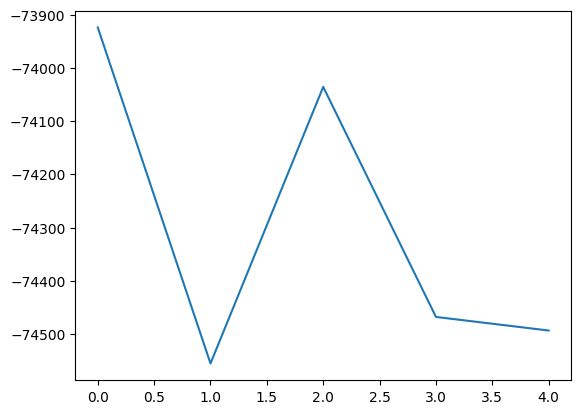


Epoca: 10

Recompensa de Media: -74295.27777746029 

1/1 [==============================] - 291s 291s/step - d_loss: 2.1185 - g_loss: 1.2635
Epoch 11/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 06:22:30,695] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:22:30,695] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:22:30,696] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:22:30,696] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:22:30,792] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run70
[2023-11-07 06:22:30,792] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run70
[2023-11-07 06:22:45,778] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -74587.05050170928
[2023-11-07 06:41:49,882] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:41:49,882] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:41:49,882] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:41:49,883] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:41:49,883] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:41:49,883] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:41:49,973] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res181/Eplus-env-sub_run2
[2023-11-07

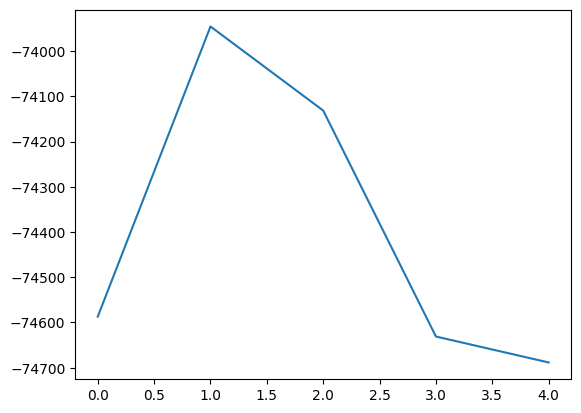


Epoca: 20

Recompensa de Media: -74396.6484574121 

1/1 [==============================] - 285s 285s/step - d_loss: 2.0716 - g_loss: 1.2767
Epoch 21/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 06:44:23,454] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:44:23,454] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:44:23,454] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 06:44:23,455] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:44:23,455] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:44:23,455] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 06:44:23,545] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus working directory is in /workspaces/sinergym/Eplus-env-office-hot-discrete-v1-res179/Eplus-env-sub_run130
[2023-11-07 06:44:23,545] EPLUS_ENV_office-hot-discre

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -74571.09613103574
[2023-11-07 07:03:16,117] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:03:16,117] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:03:16,117] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:03:16,117] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:03:16,119] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:03:16,119] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:03:16,119] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:03:16,119] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Cr

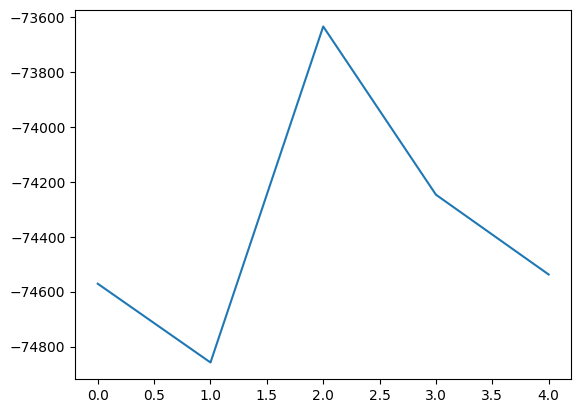


Epoca: 30

Recompensa de Media: -74369.38767200337 

1/1 [==============================] - 289s 289s/step - d_loss: 2.0597 - g_loss: 0.2576
Epoch 31/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 07:05:54,369] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:05:54,369] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:05:54,369] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:05:54,369] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:05:54,371] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:05:54,371] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:05:54,371] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:05:54,371] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...


/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -74013.79389776538
[2023-11-07 07:24:57,572] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:24:57,572] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:24:57,572] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:24:57,572] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:24:57,572] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:24:57,574] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:24:57,574] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:24:57,574] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Crea

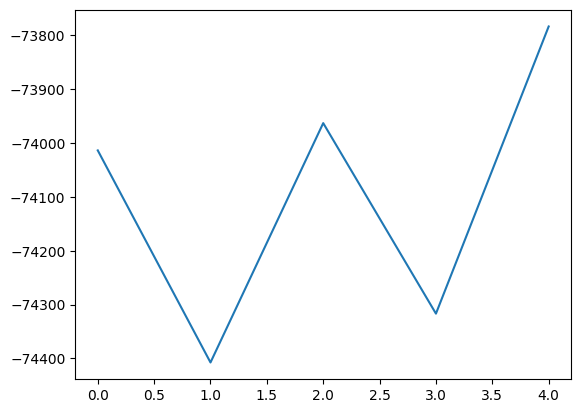


Epoca: 40

Recompensa de Media: -74096.99232377016 

1/1 [==============================] - 288s 288s/step - d_loss: 2.0540 - g_loss: 0.2552
Epoch 41/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 07:27:32,657] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:27:32,657] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:27:32,657] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:27:32,657] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:27:32,657] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:27:32,659] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:27:32,659] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:27:32,659] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -74693.57154954952
[2023-11-07 07:46:47,327] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:46:47,327] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:46:47,327] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:46:47,327] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:46:47,327] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:46:47,327] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:46:47,329] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:46:47,329] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creati

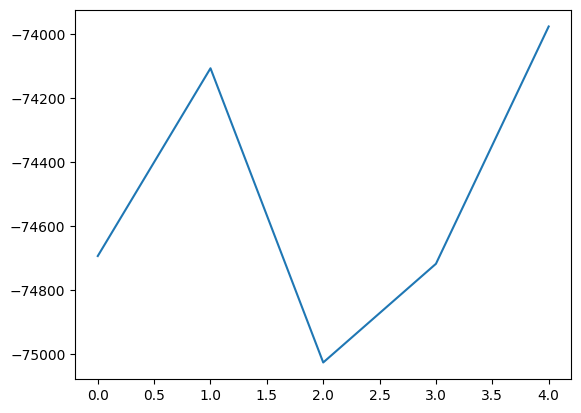


Epoca: 50

Recompensa de Media: -74504.18794637578 

1/1 [==============================] - 289s 289s/step - d_loss: 2.0530 - g_loss: -0.1990
Epoch 51/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 07:49:22,635] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:49:22,635] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:49:22,635] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:49:22,635] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:49:22,635] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:49:22,635] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 07:49:22,637] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-11-07 07:49:22,637] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[202

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -73996.61313937849
[2023-11-07 08:08:12,449] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:08:12,449] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:08:12,449] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:08:12,449] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:08:12,449] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:08:12,449] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:08:12,449] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:08:12,451] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating

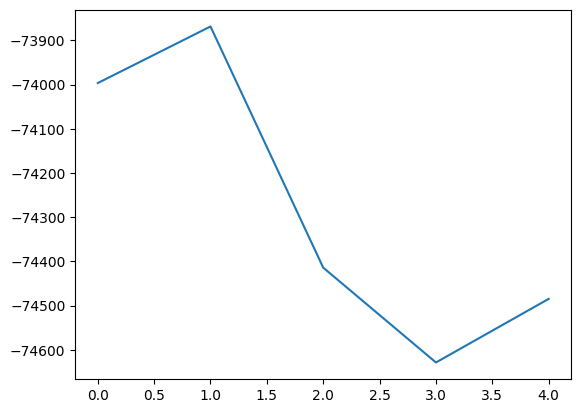


Epoca: 60

Recompensa de Media: -74278.65044454389 

1/1 [==============================] - 284s 284s/step - d_loss: 2.0494 - g_loss: 0.2838
Epoch 61/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 08:10:46,425] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:10:46,425] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:10:46,425] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:10:46,425] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:10:46,425] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:10:46,425] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:10:46,425] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:10:46,427] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:Creating new EnergyPlus simulation episode...
[2023-

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -73969.61906717603
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:30:06,028] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPl

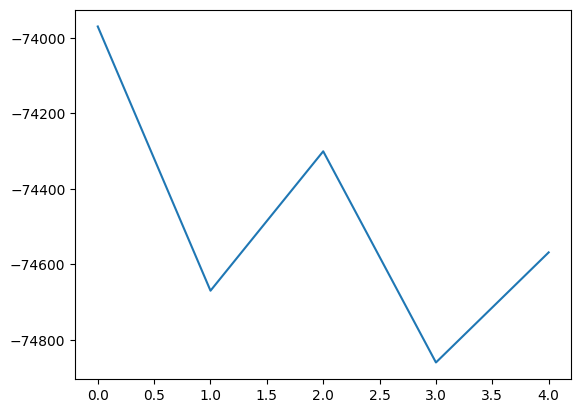


Epoca: 70

Recompensa de Media: -74473.76050295736 

1/1 [==============================] - 296s 296s/step - d_loss: 2.0523 - g_loss: -0.1620
Epoch 71/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:32:45,488] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -74265.22284343213
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:52:14,591] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPl

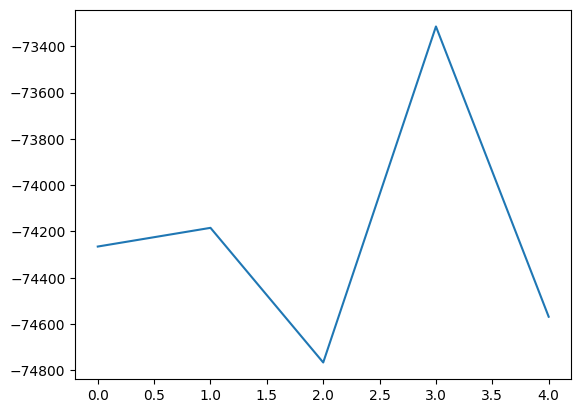


Epoca: 80

Recompensa de Media: -74219.71873919437 

1/1 [==============================] - 289s 289s/step - d_loss: 2.0536 - g_loss: 0.3617
Epoch 81/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 08:54:47,552] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -74253.29821330297
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:14:20,359] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPl

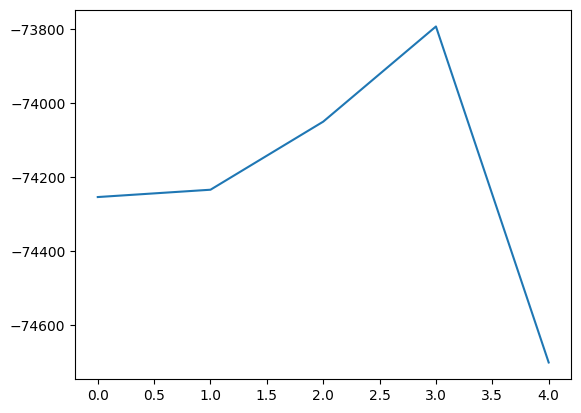


Epoca: 90

Recompensa de Media: -74205.85805089728 

1/1 [==============================] - 306s 306s/step - d_loss: 2.0510 - g_loss: 0.2979
Epoch 91/100


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:17:05,860] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11

/usr/local/lib/python3.10/dist-packages/opyplus/weather_data/weather_data.py:493: FutureWarning: the 'line_terminator'' keyword is deprecated, use 'lineterminator' instead.
  epw_content = self._headers_to_epw(use_datetimes=use_datetimes) + df.to_csv(


Episode  0 Total reward: -75370.63534209401
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:37:02,340] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPl

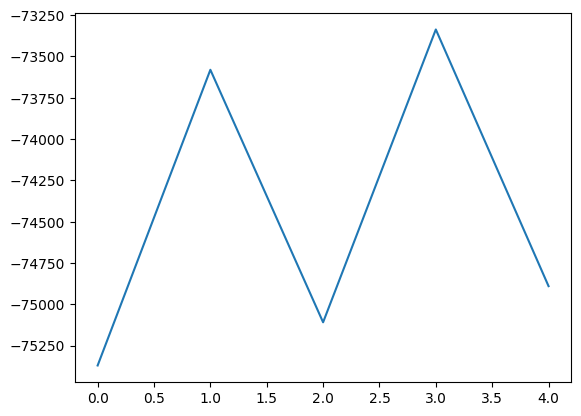


Epoca: 100

Recompensa de Media: -74457.76103633324 

1/1 [==============================] - 374s 374s/step - d_loss: 2.0522 - g_loss: -0.1583


In [18]:
# Deshabilitar los mensajes de información de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Deshabilitar los mensajes de información de OpenAI Gym
gym.logger.set_level(40)

# Entrenamiento GAIL
history = gan.fit(X_train,epochs=EPOCHS, batch_size=BATCH_SIZE)

### Evaluación de Extended GAIL

In [19]:
gan.evaluate_D(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11-07 09:40:37,408] EPLUS_ENV_office-hot-discrete-v1_MainThread_ROOT INFO:EnergyPlus episode completed successfully. 
[2023-11

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 39ms/step - loss: 1.3080e-09 - accuracy: 0.0000e+00
>Accuracy real: 0%, fake: 0%
>Loss real: 
1.0461446153797738e-09
>Loss fake: 
1.308015917800276e-09


# Análisis de experimentos 

In [20]:
# Librerias necesarias para la visualización
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 

## Experimento 1

In [22]:
x=[10,20,30,40,50,60,70,80,90,100]
y=[-74295.27,-74396.64,-74369.38,-74096.99,-74504.18,-74278.65,-74473.76,-74219.71,-74205.85,-74457.76]

df = pd.DataFrame({'x': x, 'y': y})

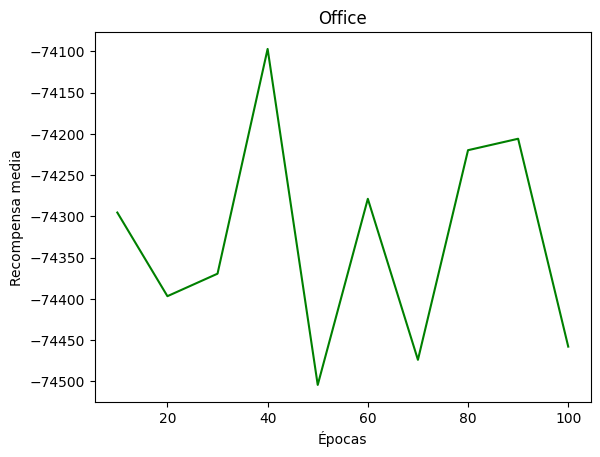

In [23]:
plt.plot(x, y, label='Office',color='green')

#Agregamos las etiquetas y añadimos una leyenda.
plt.xlabel('Épocas')
plt.ylabel('Recompensa media')
plt.title("Office")
# plt.legend()
plt.savefig('grafica_Office_Extended_Gail.png')
plt.show()

### Estimación estadística: Modelo de Regresión Lineal 

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


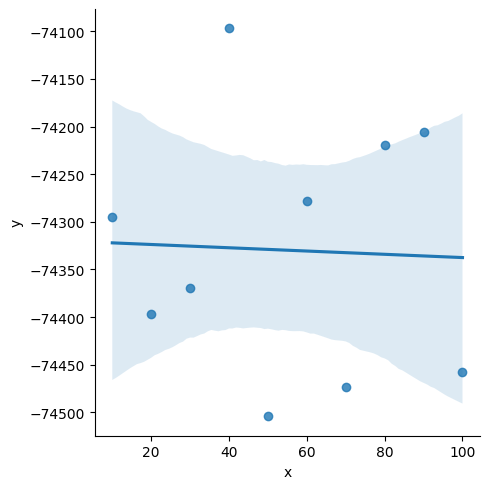

In [24]:
sns.lmplot(data=df, x="x", y="y")

### Representación de distribuciones
Los análisis estadísticos requieren conocimiento sobre la distribución de variables en tu conjunto de datos. Estos conocimientos incluyen técnicas clásicas como histogramas y otros enfoques computacionalmente mas intensos como la estimación de densidad de kernel que vamos a ver a continuación con objeto de ver en que subgrupo hay una mayor cantidad de datos.  

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


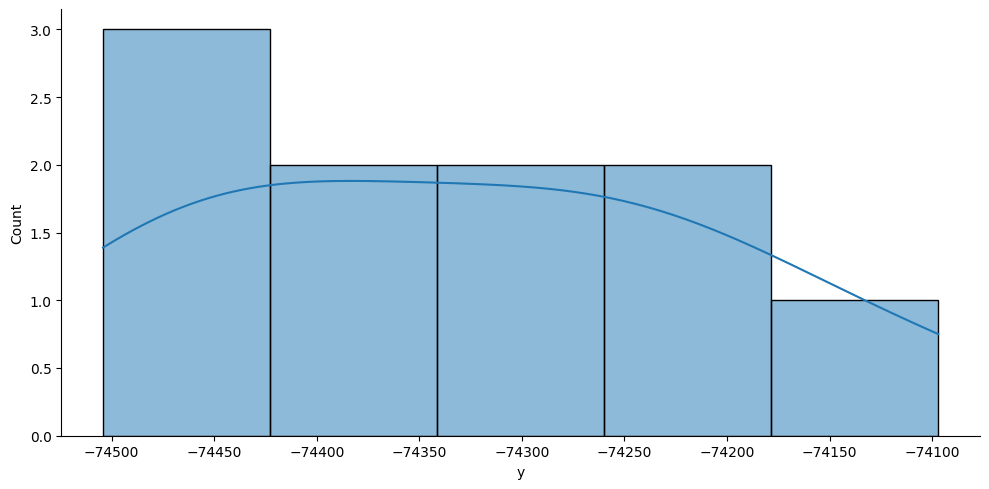

In [25]:
sns.displot(data=df, x="y", aspect=2, kde=True)

Calculamos y representamos gráficamente la "función de distribución acumulativa empírica(ECDF)" de los datos:

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


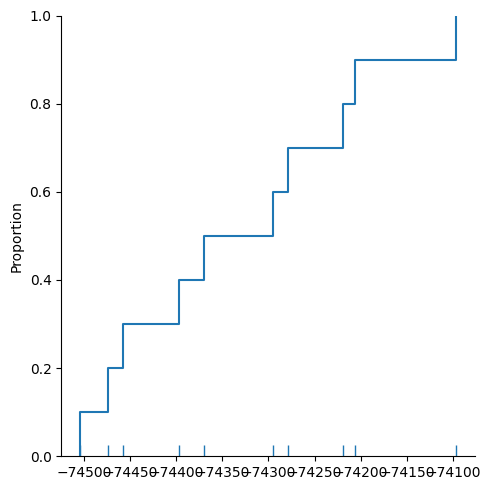

In [26]:
# -rug=True ------> Agrega líneas verticales ("pelusas") en el eje x para representar cada punto de datos. Esto proporciona una representación visual de la distribución de los datos
sns.displot(data=df, kind="ecdf", x=y, rug=True)

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


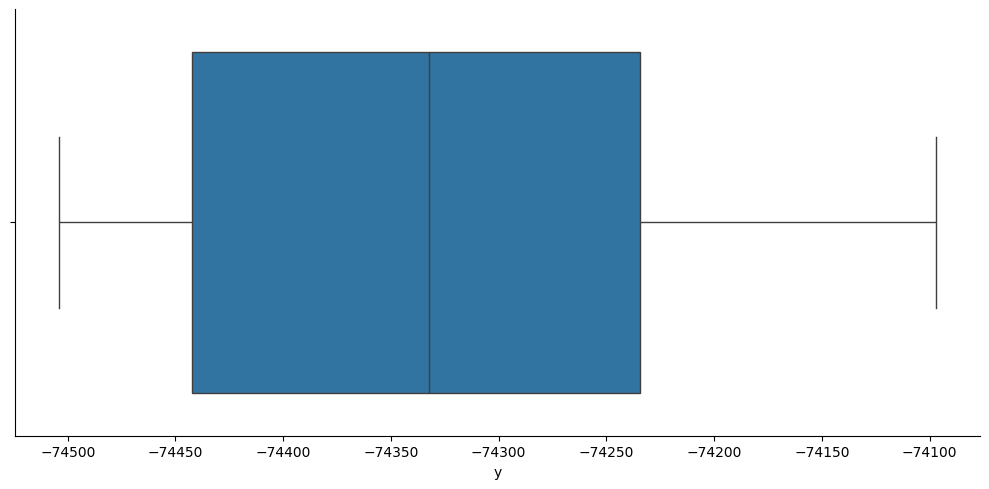

In [27]:
sns.catplot(x="y", data=df,  aspect=2, kind="box")
plt.show()

### Visualización de datos categóricos
Vemos cada observación mediante un "swarm plot": un gráfico de dispersión que ajusta las posiciones de los puntos a lo largo del eje categórico para evitar que se superpongan:

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


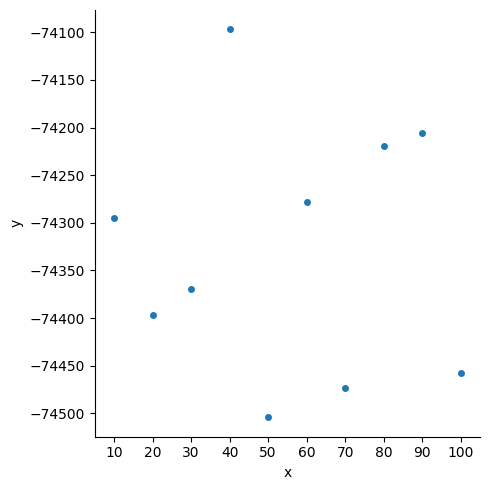

In [28]:
sns.catplot(data=df, kind="swarm", x="x", y="y")

Como no tenemos mas de un punto en cada época, no tiene sentido utilizar la estimación de densidad de núcleo para representar la distribución subyacente de la cual se muestrean los puntos de cada valor de x. Tampoco tiene sentido, estudiar la media ya que solo tenemos un punto para cada valor de x.

### Vistas multivariadas

Algunas funciones de seaborn combinan varios tipos de gráficos para proporcionar rápidamente resúmenes informativos de un conjunto de datos. Uno de ellos, jointplot(), se centra en una única relación. En nuestro caso, nos centramos en la **relación Recompensa media\Épocas**.

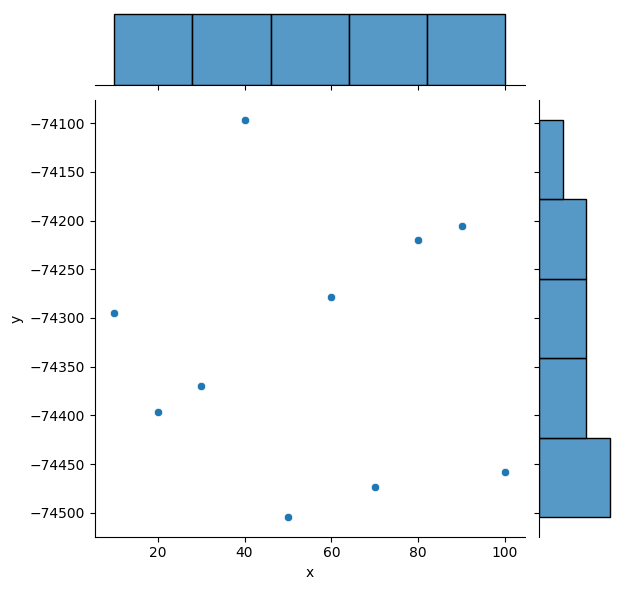

In [29]:
sns.jointplot(data=df, x="x", y="y")

Mostramos las distribuciones conjuntas y marginales para todas las relaciones de a pares y para cada variable, respectivamente:

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


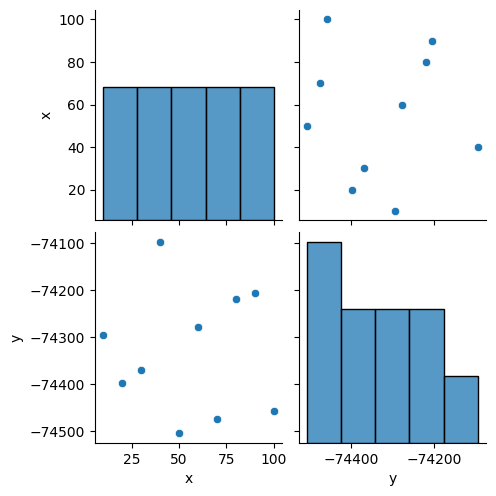

In [30]:
sns.pairplot(data=df)

## Herramientas de nivel inferior para construir gráficos
*  **g = sns.PairGrid(df, corner=True)**: Esta línea crea un conjunto de gráficos de pares (Pair Grid). Un conjunto de gráficos de pares es una cuadrícula de subgráficos que muestra las relaciones entre pares de variables en un conjunto de datos.
*  **g.map_lower(sns.kdeplot, hue=None, levels=5, color=".2")**:  mapea una función a los gráficos en la parte inferior de la cuadrícula (map_lower). En este caso, se utiliza la función sns.kdeplot, que crea gráficos de densidad de kernel. Los argumentos adicionales son levels=5 (se especifica el número de niveles en el gráfico de densidad) y color=".2" (se especifica el color de las curvas de densidad).
* **g.map_lower(sns.scatterplot, marker="+")**: Esta línea mapea la función sns.scatterplot a los gráficos en la parte inferior de la cuadrícula. Esto creará gráficos de dispersión. El argumento adicional marker="+" indica que se utilizará el signo "+" como marcador en el gráfico de dispersión.

* **g.map_diag(sns.histplot, element="step", linewidth=0, kde=True)**: Esta línea mapea la función sns.histplot a los gráficos en la diagonal principal de la cuadrícula. Esto creará histogramas. Los argumentos adicionales element="step" (especifica el tipo de elemento de trazado, en este caso, escalones) y linewidth=0 (especifica el ancho de línea) se utilizan para personalizar la apariencia del histograma. kde=True indica que se incluirá también una estimación de densidad de kernel.

* **g.add_legend(frameon=True)**: Esta línea agrega una leyenda a los gráficos. frameon=True indica que se dibujará un marco alrededor de la leyenda.

* **g.legend.set_bbox_to_anchor((.61, .6))**: Esta línea ajusta la posición de la leyenda dentro de la cuadrícula.

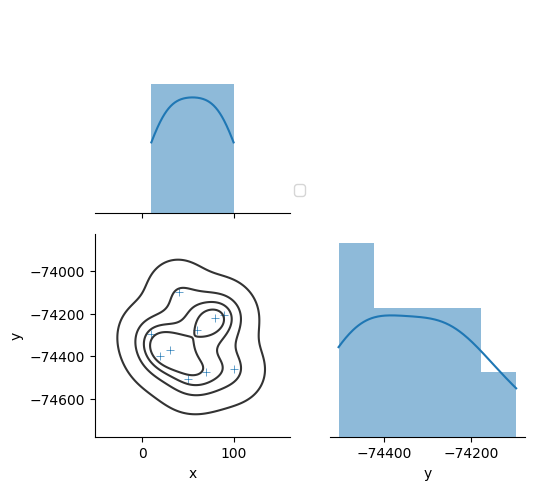

In [31]:
g = sns.PairGrid(df, corner=True)
g.map_lower(sns.kdeplot, hue=None, levels=5, color=".2")
g.map_lower(sns.scatterplot, marker="+")
g.map_diag(sns.histplot, element="step", linewidth=0, kde=True)
g.add_legend(frameon=True)
g.legend.set_bbox_to_anchor((.61, .6))